In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os
import re
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.signal import find_peaks
from scipy import signal

# Copy Data From Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!unzip -q -d ./ /gdrive/My\ Drive/cells.zip

In [4]:
DATA_DIR = "cells"
files = os.listdir(DATA_DIR)

# sort files by batch and cell number
def sort_key(f):
  match = re.match(r"^b(\d+)c(\d+)", f)
  batch, cell = int(match[1]), int(match[2])
  return batch * 1000 + cell

files.sort(key=sort_key)
files = np.array(files)

In [5]:
def get_cell_data(cell):
  return pickle.load(open(os.path.join(DATA_DIR, cell), "rb"))

# Split data as done in paper

In [6]:
# split data in the same way as paper
numBat1 = len([f for f in files if f.startswith("b1")])
numBat2 = len([f for f in files if f.startswith("b2")])
numBat3 = len([f for f in files if f.startswith("b3")])
numBat = numBat1 + numBat2 + numBat3

# test data
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))

# train data
train_ind = np.arange(1,(numBat1+numBat2-1),2)

# the authors acquired this data after model developement
secondary_test_ind = np.arange(numBat-numBat3,numBat)

# clean batch 2 data

* spikes around ~250 cycle all cells
* channel 3 computer restarted during end
* channel 7, 21 thermocouple disconnected
* channel 15, 16 thermocouple switched
* channel 10 dies quickly its probably defective

Since We dont have channel_id or cell_id    available in pkl files we use info from supplementary pdf to find those cells

```
Channel, Cell Id, Cycle Life, Recharge Policy, Split of corrupted cells obtained from supplemenary pdf.

3    el150800460623 2237 3.6C(80%)-3.6C    test
7    el150800460611 461  4.8C(80%)-4.8C    train
21   el150800460603 489  4.65C(19%)-4.85C  train
15   el150800460634 511  3.6C(30%)-6C      train
16   el150800460451 561  3.6C(9%)-5C       test
10   el150800460605 148  2C(10%)-6C        test
```


In [7]:
defective_cells = [
    (3, 2237, '3.6C(80%)-3.6C'),
    (7, 461, '4.8C(80%)-4.8C'),
    (21, 489, '4.65C(19%)-4.85C'),
    (15, 511, '3.6C(30%)-6C'),
    (16, 561, '3.6C(9%)-5C'),
    (10, 148, '2C(10%)-6C'),
]

defective_cells_found = []

for i, f in enumerate(files):
  cell_data = get_cell_data(f)
  cycle_life = cell_data['cycle_life'][0][0]
  policy = cell_data['policy']
  for cell in defective_cells:
    if cell[1] == cycle_life and cell[2] == policy:
      defective_cells_found.append((cell[0], i, f))

In [8]:
defective_cells_found

[(3, 2, 'b1c2.pkl'),
 (10, 42, 'b2c1.pkl'),
 (15, 47, 'b2c6.pkl'),
 (16, 48, 'b2c10.pkl'),
 (21, 57, 'b2c21.pkl'),
 (7, 61, 'b2c25.pkl')]

In [9]:
# remove 7, 21, 15, 16, 10 from train_ind, test_ind
remove_channels = [7, 21, 15, 16, 10]
remove_ind = [c[1] for c in defective_cells_found if c[0] in remove_channels]

train_ind = np.array([ind for ind in train_ind if ind not in remove_ind])
test_ind = np.array([ind for ind in test_ind if ind not in remove_ind])
secondary_test_ind = np.array([ind for ind in secondary_test_ind if ind not in remove_ind])

In [10]:
batch2_sample = get_cell_data([f for f in files if f.startswith("b2")][10])

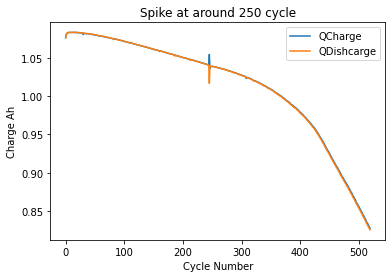

In [11]:
plt.plot(batch2_sample['summary']['QCharge'], label='QCharge')
plt.plot(batch2_sample['summary']['QDischarge'], label='QDishcarge')
plt.legend()
plt.ylabel('Charge Ah')
plt.xlabel('Cycle Number')
plt.title("Spike at around 250 cycle");

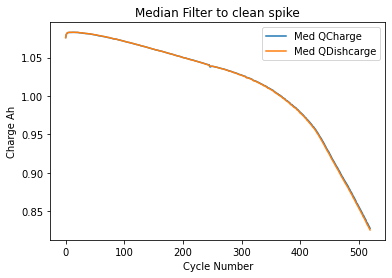

In [12]:
plt.plot(signal.medfilt(batch2_sample['summary']['QCharge']), label='Med QCharge')
plt.plot(signal.medfilt(batch2_sample['summary']['QDischarge']), label='Med QDishcarge')
plt.legend()
plt.ylabel('Charge Ah')
plt.xlabel('Cycle Number')
plt.title("Median Filter to clean spike");

In [13]:
# change get_cell_data to remove spikes
def get_cell_data(cell, apply_filter=True):
  cell_data = pickle.load(open(os.path.join(DATA_DIR, cell), "rb"))
  if apply_filter:
    cell_data['summary']['QCharge'] = signal.medfilt(cell_data['summary']['QCharge'])
    cell_data['summary']['QDischarge'] = signal.medfilt(cell_data['summary']['QDischarge'])
  return cell_data

# historgram of battery life

In [14]:
cycle_life = np.array([get_cell_data(f, False)['cycle_life'][0][0] for f in files])

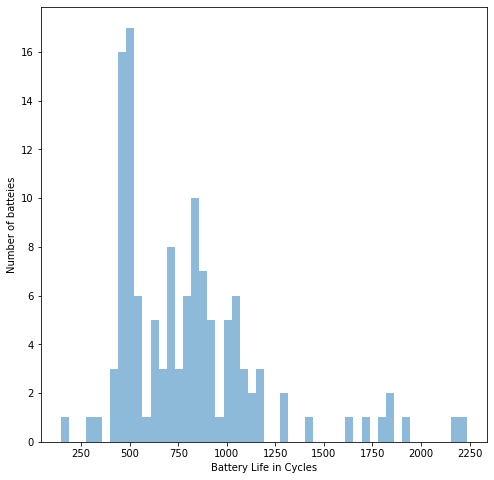

In [15]:
plt.figure(figsize=(8, 8))
plt.hist(cycle_life, bins=50, alpha=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlabel('Battery Life in Cycles')
plt.ylabel('Number of batteies');

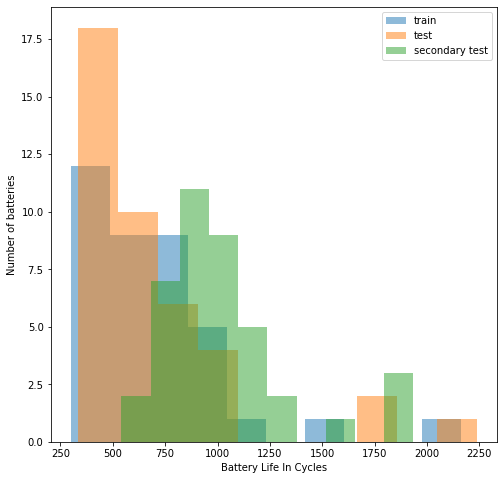

In [16]:
plt.figure(figsize=(8, 8))

indices = [train_ind, test_ind, secondary_test_ind]
splits = ['train', 'test', 'secondary test']

for ind, split in zip(indices, splits):
  plt.hist(cycle_life[ind], label=split, alpha=0.5)

plt.xlabel('Battery Life In Cycles')
plt.ylabel('Number of batteries')
plt.legend();

In [17]:
cycle_life_sorted_indices = np.argsort(cycle_life)

top3, top3_life = files[cycle_life_sorted_indices[-3:]], cycle_life[cycle_life_sorted_indices[-3:]]

bottom3, bottom3_life = files[cycle_life_sorted_indices[:3]], cycle_life[cycle_life_sorted_indices[:3]]

print("Top 3 life")
print(list(zip(top3[::-1], top3_life[::-1])))
print()

print("Bottom 3 life")
print(list(zip(bottom3, bottom3_life)))
print()

Top 3 life
[('b1c2.pkl', 2237.0), ('b1c1.pkl', 2160.0), ('b3c38.pkl', 1935.0)]

Bottom 3 life
[('b2c1.pkl', 148.0), ('b2c0.pkl', 300.0), ('b2c3.pkl', 335.0)]



# how battery ages

In [18]:
def plot_summary(cell, axs):
  cell_data = get_cell_data(cell)
  
  summary = cell_data['summary']
  life = cell_data['cycle_life'][0][0]

  for f in ['Tavg', 'Tmin', 'Tmax', 'chargetime']:
    axs[0].set_title(f"Cell {cell.split('.')[0]} Lifespan {life} cycles")
    axs[0].set_xlabel('Cycle')
    axs[0].plot(summary['cycle'], summary[f], label=f, alpha=0.5)

  for f in ['QCharge', 'QDischarge']:
    axs[1].plot(summary['cycle'], summary[f], label=f, alpha=0.5)

  lag = 10
  for f in ['QCharge', 'QDischarge']:
    axs[2].plot(summary['cycle'][lag:], (summary[f][:-lag] - summary[f][lag:]), label=f"delta {f} ({lag} cycles lag)", alpha=0.5)

  for f in ['IR']:
    axs[3].plot(summary['cycle'], summary[f], label=f, alpha=0.5)

  for ax in axs:
    ax.legend()

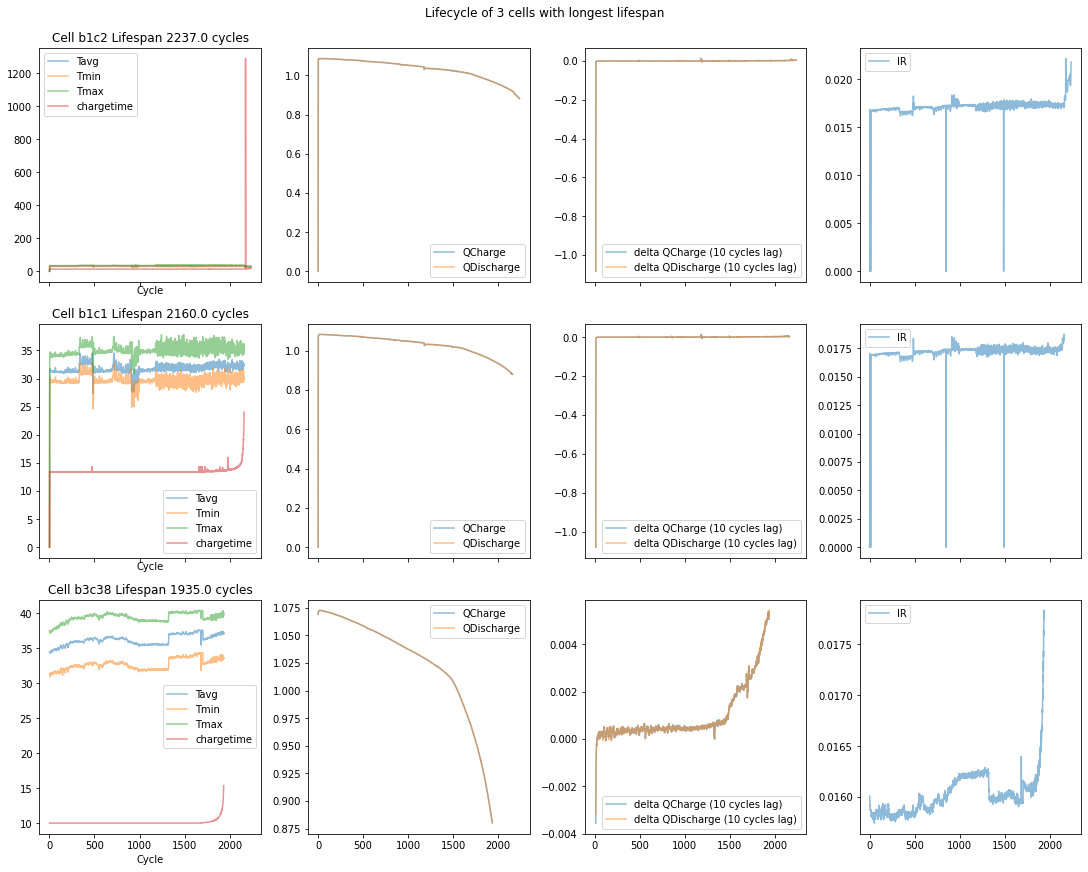

In [19]:
cells = top3[::-1]

fig, axs = plt.subplots(len(cells), 4, figsize=(15, 4*cells.shape[0]), sharex=True, constrained_layout=True)
fig.suptitle('Lifecycle of 3 cells with longest lifespan')

for i in range(cells.shape[0]):
  plot_summary(cells[i], axs[i].ravel())

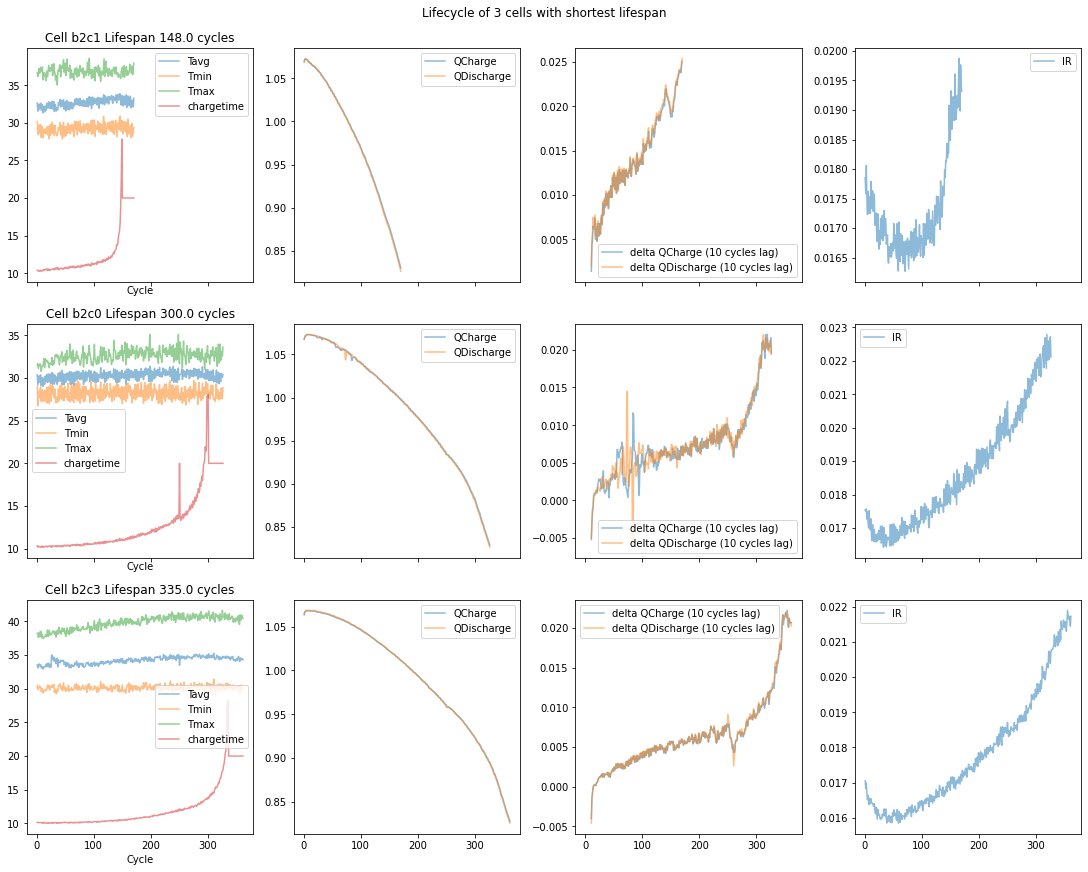

In [20]:
cells = bottom3

fig, axs = plt.subplots(len(cells), 4, figsize=(15, 4*cells.shape[0]), sharex=True, constrained_layout=True)
fig.suptitle('Lifecycle of 3 cells with shortest lifespan')

for i in range(cells.shape[0]):
  plot_summary(cells[i], axs[i].ravel())

* long lived batteries have modest increase in chargetime as they age
* short lived batteries have sharp increase in chargetime as they age
* contrary to whats mentioned in the paper, a cell is not considered unfit for use when its nominal capacity reaches 0.80, sometimes its 0.88 other times its 0.82
* slope of QDischarge, QCharge curve is good indicator of lifecycle of battery
* internal resistance increases over time

# Look at good features for extrapolation

In [21]:
example_cell = files[10]
cell_data = get_cell_data(example_cell, False)

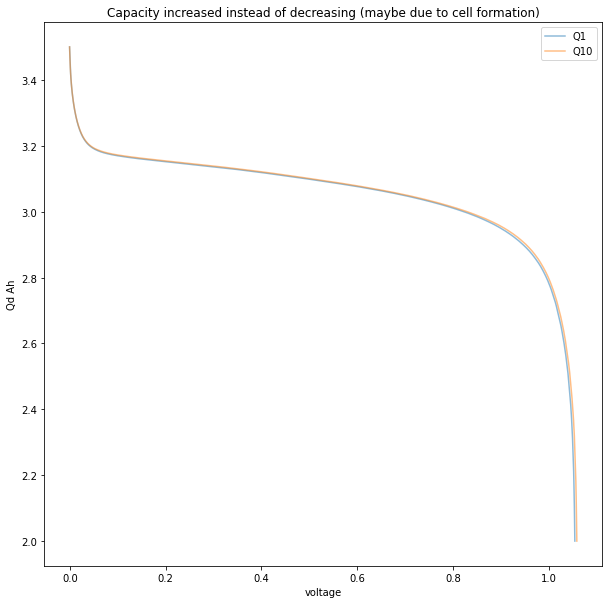

In [22]:
plt.figure(figsize=(10, 10))
q1 = cell_data['cycles'][1]['Qdlin']
q10 = cell_data['cycles'][10]['Qdlin']
v = cell_data['vdlin'][0]
plt.plot(q1, v, label='Q1', alpha=0.5)
plt.plot(q10, v, label='Q10',alpha=0.5 )
plt.xlabel('voltage')
plt.ylabel('Qd Ah')
plt.title("Capacity increased instead of decreasing (maybe due to cell formation)")
plt.legend();

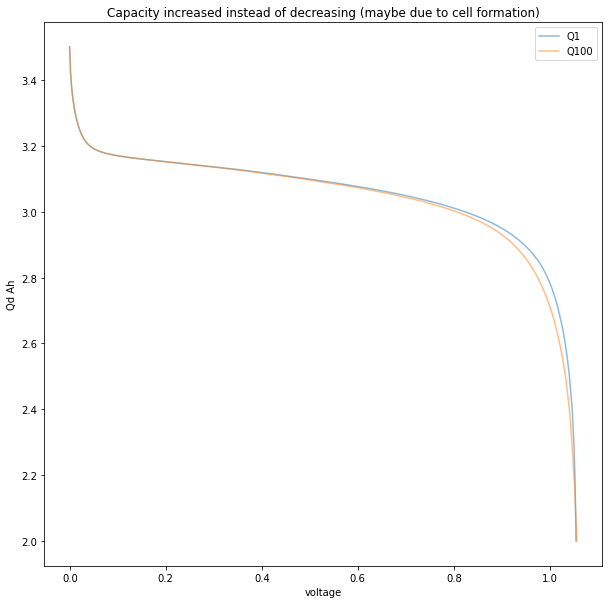

In [23]:
plt.figure(figsize=(10, 10))
q1 = cell_data['cycles'][1]['Qdlin']
q100 = cell_data['cycles'][100]['Qdlin']
v = cell_data['vdlin'][0]
plt.plot(q1, v, label='Q1', alpha=0.5)
plt.plot(q100, v, label='Q100',alpha=0.5 )
plt.xlabel('voltage')
plt.ylabel('Qd Ah')
plt.title("Capacity increased instead of decreasing (maybe due to cell formation)")
plt.legend();

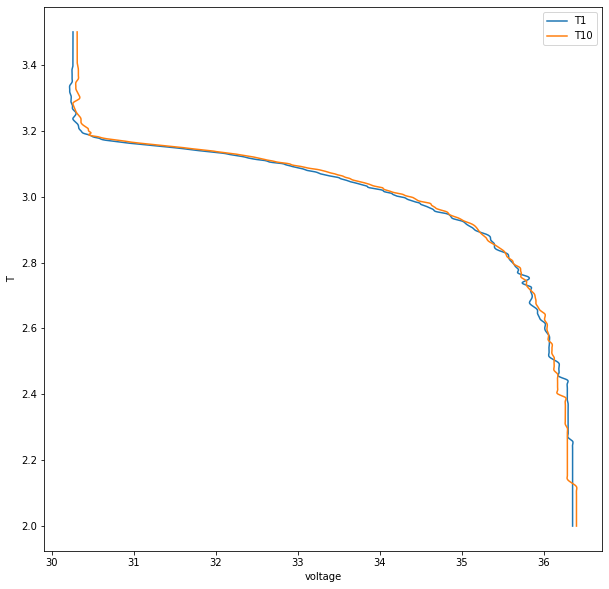

In [24]:
plt.figure(figsize=(10, 10))
t10 = cell_data['cycles'][1]['Tdlin']
t100 = cell_data['cycles'][10]['Tdlin']
v = cell_data['vdlin'][0]
plt.plot(t10, v, label='T1')
plt.plot(t100, v, label='T10')
plt.xlabel('voltage')
plt.ylabel('T')
plt.legend();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


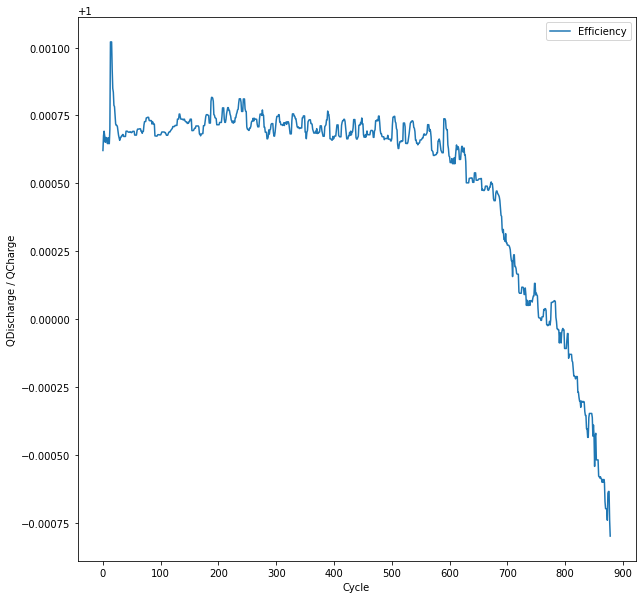

In [25]:
plt.figure(figsize=(10, 10))

efficiency = (cell_data['summary']['QDischarge']) / cell_data['summary']['QCharge']
efficiency = signal.medfilt(efficiency, kernel_size=5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.plot(efficiency, label='Efficiency');
plt.xlabel('Cycle')
plt.ylabel('QDischarge / QCharge')
plt.legend();

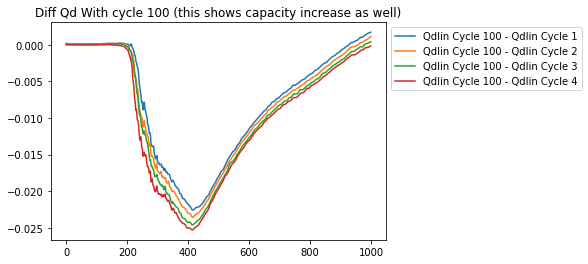

In [26]:
diff_wrt = 100

for i in range(1, 5):
  plt.plot(cell_data['cycles'][diff_wrt]['Qdlin'] - cell_data['cycles'][i]['Qdlin'], 
           label=f'Qdlin Cycle {diff_wrt} - Qdlin Cycle {i}')

plt.title(f'Diff Qd With cycle {diff_wrt} (this shows capacity increase as well)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

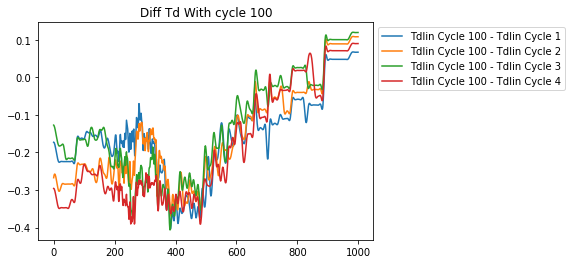

In [27]:
diff_wrt = 100

for i in range(1, 5):
  plt.plot(cell_data['cycles'][diff_wrt]['Tdlin'] - cell_data['cycles'][i]['Tdlin'], 
           label=f'Tdlin Cycle {diff_wrt} - Tdlin Cycle {i}')

plt.title(f'Diff Td With cycle {diff_wrt}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

# Fast Charging

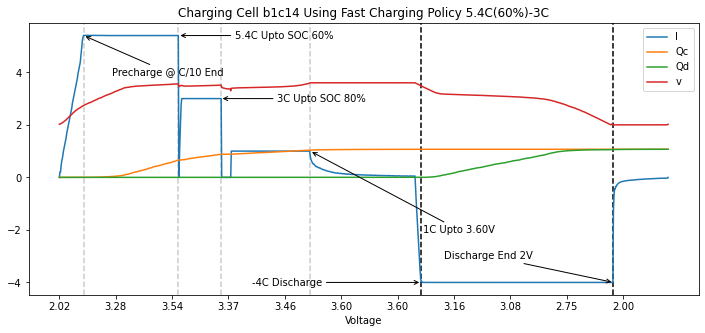

In [28]:
plt.figure(figsize=(12, 5))
plt.title(f"Charging Cell {example_cell.split('.')[0]} Using Fast Charging Policy {cell_data['policy']}")

cycle_number = 1
t = cell_data['cycles'][cycle_number]['t']
v = cell_data['cycles'][cycle_number]['V']
i = cell_data['cycles'][cycle_number]['I']
qc = cell_data['cycles'][cycle_number]['Qc']
qd = cell_data['cycles'][cycle_number]['Qd']
nominal_capacity = 1.1

precharge_end = np.argwhere(i >= 5.4)[0][0]
soc60 = np.argwhere(qc > 0.6*nominal_capacity)[0][0]
soc80 = np.argwhere(qc > 0.8*nominal_capacity)[0][0]
onec_end = np.argwhere(v >= 3.60)[0][0]
discharge_start = np.argwhere(qd > 0.0001)[0][0]
discharge_end = np.argwhere(v <= 2)[0][0]

plt.annotate('Precharge @ C/10 End', 
               xy=(precharge_end, 5.4),
               xytext=(precharge_end+50, 4), 
               arrowprops=dict(arrowstyle='->'),
               va='center')

plt.annotate('5.4C Upto SOC 60%', 
               xy=(soc60, 5.4), 
               xytext=(soc60+100, 5.4), 
               arrowprops=dict(arrowstyle='->'),
               va='center')

plt.annotate('3C Upto SOC 80%', 
              xy=(soc80, 3), 
              xytext=(soc80+100, 3), 
              arrowprops=dict(arrowstyle='->'),
              va='center')

plt.annotate('1C Upto 3.60V', 
              xy=(onec_end, 1),
              xytext=(onec_end + 200, -2), 
              arrowprops=dict(arrowstyle='->'),
              va='center')

plt.annotate('-4C Discharge',
              xy=(discharge_start, -4), 
              xytext=(discharge_start-300, -4), 
              arrowprops=dict(arrowstyle='->'),
              va='center')

plt.annotate('Discharge End 2V',
              xy=(discharge_end, -4), 
              xytext=(discharge_end-300, -3), 
              arrowprops=dict(arrowstyle='->'),
              va='center')

plt.axvline(x=precharge_end, linestyle='--', color='#ccc')
plt.axvline(x=soc60, linestyle='--', color='#ccc')
plt.axvline(x=soc80, linestyle='--', color='#ccc')
plt.axvline(x=onec_end, linestyle='--', color='#ccc')
plt.axvline(x=discharge_start, linestyle='--', color='#000')
plt.axvline(x=discharge_end, linestyle='--', color='#000')

plt.plot(i, label='I')
plt.plot(qc, label='Qc')
plt.plot(qd, label='Qd')
plt.plot(v, label='v')

plt.gca().set_xticks(range(len(v))[::100])
plt.gca().set_xticklabels([f"{volts:0.2f}" for volts in v][::100])
plt.xlabel('Voltage')
plt.legend();

# Qc is the total Charge that went into the cell
# Qd i the total Charge that came out of cell
# At the end of discharge Qc-Qd Should be as low as possible

# https://www.mpoweruk.com/life.htm

In [29]:
np.sum([np.diff(cell_data['cycles'][1]['t']) * cell_data['cycles'][1]['T'][1:]])

1709.1563633206601

# Find features with high correlation with cycle life

per cycle data

'I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'discharge_dQdV', 't'



summary

'IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle'

In [77]:
# manual features as described in paper
def make_features(last_cycle=100, first_cycle=10):
  assert first_cycle > 2, "first_cycle must be > 2"
  assert last_cycle > first_cycle, "last_cycle must be > first_cycle"

  features = []
  
  def slope_cap_fade_curve(data):
    fade_curve = data['summary']['QDischarge'][2:last_cycle]
    p = np.polyfit(np.arange(len(fade_curve)), fade_curve, deg=1)
    return p[0]

  def intercept_cap_fade_curve(data):
    fade_curve = data['summary']['QDischarge'][2:last_cycle]
    p = np.polyfit(np.arange(len(fade_curve)), fade_curve, deg=1)
    return p[1]

  def slope_cap_fade_curve_end(data):
    fade_curve = data['summary']['QDischarge'][91:100]
    p = np.polyfit(np.arange(len(fade_curve)), fade_curve, deg=1)
    return p[0]

  def intercept_cap_fade_curve_end(data):
    fade_curve = data['summary']['QDischarge'][91:100]
    p = np.polyfit(np.arange(len(fade_curve)), fade_curve, deg=1)
    return p[1]

  def temperature_integral(data):
    return np.sum(data['summary']['Tavg'] * data['summary']['chargetime'])
    # sum = 0
    # for i in range(2, last_cycle):
    #   sum += np.sum([np.diff(data['cycles'][i]['t']) * data['cycles'][i]['T'][1:]])
    # return sum

  # Variance Features

  features.append((
      f"min(Q{last_cycle}-Q{first_cycle})",
      lambda data : np.min(data['cycles'][last_cycle]['Qdlin'] - data['cycles'][first_cycle]['Qdlin'])
  ))

  features.append((
      f"mean(Q{last_cycle}-Q{first_cycle})",
      lambda data : np.mean(data['cycles'][last_cycle]['Qdlin'] - data['cycles'][first_cycle]['Qdlin'])
  ))

  features.append((
      f"var(Q{last_cycle}-Q{first_cycle})",
      lambda data : np.var(data['cycles'][last_cycle]['Qdlin'] - data['cycles'][first_cycle]['Qdlin'])
  ))

  features.append((
      f"Q{last_cycle}-Q{first_cycle})@2v",
      lambda data : data['cycles'][last_cycle]['Qdlin'][-1] - data['cycles'][first_cycle]['Qdlin'][-1]
  ))

  # Discharge FEatures
  features.append((
      f"Slope Cap Fade Curve cycle 2 to {last_cycle}",
      slope_cap_fade_curve,
  ))

  features.append((
      f"Intercept Cap Fade Curve cycle 2 to {last_cycle}",
      intercept_cap_fade_curve,
  ))

  features.append((
      f"Slope Cap Fade Curve cycle 2 to {last_cycle}",
      slope_cap_fade_curve,
  ))

  features.append((
      f"Intercept Cap Fade Curve cycle 2 to {last_cycle}",
      intercept_cap_fade_curve,
  ))

  features.append((
      f"Slope Cap Fade Curve cycle 91 to 100",
      slope_cap_fade_curve_end,
  ))

  features.append((
      f"Intercept Cap Fade Curve cycle 91 to 100",
      intercept_cap_fade_curve_end,
  ))

  features.append((
      "QDischarge @ cycle 2",
      lambda data : data['summary']['QDischarge'][2],
  ))

  features.append((
      "Max QDischarge - QDischarge Cycle 2",
      lambda data : np.max(data['summary']['QDischarge']) - data['summary']['QDischarge'][2]
  ))

  features.append((
      "QDischarge @ cycle 100",
      lambda data : data['summary']['QDischarge'][100],
  ))


  # Other Features
  features.append((
      "Avg Charge Time First 5 Cycles",
      lambda data : np.mean(data['summary']['chargetime'][1:6])
  ))

  features.append((
      "Max Tavg Cycles 2:100",
      lambda data : np.max(data['summary']['Tavg'][2:100])
  ))

  features.append((
      "Min Tavg Cycles 2:100",
      lambda data : np.min(data['summary']['Tavg'][2:100])
  ))

  features.append((
      "sum(T*dt) Cycle 2:100",
      temperature_integral,
  ))

  features.append((
      f"IR Cycle 2 - IR Cycle {last_cycle}",
      lambda data : np.min(data['summary']['IR'][last_cycle] - data['summary']['IR'][2]),
  ))

  features.append((
      f"Min IR Cycle 2:{last_cycle}",
      lambda data : np.min(data['summary']['IR'][2:last_cycle]),
  ))

  features.append((
      f"IR Cycle 100 - IR Cycle {last_cycle}",
      lambda data : data['summary']['IR'][100] - data['summary']['IR'][2],
  ))

  return features

In [78]:
features = make_features(100, 10)

In [79]:
subset = np.concatenate((secondary_test_ind, test_ind))
train_files = files[subset]
train_cycle_life = np.log(cycle_life[subset])

computed_features = np.zeros((len(features), len(train_files)))

for i, f in enumerate(train_files):
  cell_data = get_cell_data(f)
  for j, feature in enumerate(features):
    name, compute = feature
    computed_features[j, i] = compute(cell_data)

corrs = [np.corrcoef(f, train_cycle_life)[0][1] for f in computed_features]

In [80]:
series = (pd.Series(corrs, index=[f[0] for f in features])
  .sort_values(
    key=np.abs, 
    ascending=False
))

with pd.option_context('display.max_rows', None):
  print(len(series))
  print(series)

20
sum(T*dt) Cycle 2:100                       0.919261
mean(Q100-Q10)                              0.809448
min(Q100-Q10)                               0.778532
var(Q100-Q10)                              -0.712179
Q100-Q10)@2v                                0.654200
Avg Charge Time First 5 Cycles              0.450420
Slope Cap Fade Curve cycle 91 to 100        0.413722
Slope Cap Fade Curve cycle 2 to 100         0.287474
Slope Cap Fade Curve cycle 2 to 100         0.287474
Min IR Cycle 2:100                         -0.258054
Min Tavg Cycles 2:100                       0.204762
Max QDischarge - QDischarge Cycle 2        -0.199472
Max Tavg Cycles 2:100                       0.183436
Intercept Cap Fade Curve cycle 2 to 100    -0.172435
Intercept Cap Fade Curve cycle 2 to 100    -0.172435
IR Cycle 100 - IR Cycle 100                 0.141236
IR Cycle 2 - IR Cycle 100                   0.141236
QDischarge @ cycle 2                       -0.131583
Intercept Cap Fade Curve cycle 91 to 100   

In [81]:
selected_features_names = series.index.to_numpy()
selected_features = [f for f in features if f[0] in selected_features_names]

# train a baseline model on those features

In [82]:
def extract_features(feature_computers, files):
  x = np.zeros((len(files), len(feature_computers)))
  for i, f in enumerate(files):
    cell_data = get_cell_data(f)
    for j, feat in enumerate(feature_computers):
      compute = feat[1]
      x[i, j] = compute(cell_data)
  return x

In [83]:
def get_xy(files_ind):
  X = extract_features(selected_features, files[files_ind])
  y = np.log(cycle_life[files_ind])
  return X, y

In [84]:
train_x, train_y = get_xy(train_ind)

reg = RidgeCV(cv=5)
reg.fit(train_x, train_y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [85]:
reg.coef_

array([ 2.84287584e-01,  1.66490547e-01, -4.45762444e-03,  1.70439637e-01,
        1.00247684e-03,  1.18688941e-01,  1.00247684e-03,  1.18688941e-01,
        1.80840113e-03,  2.13378473e-01,  1.39769316e-01, -4.17584520e-03,
        2.31054209e-01, -3.80870196e-02,  1.20315314e-01, -5.64199538e-02,
        2.71582477e-06,  5.50457958e-03, -6.32790759e-02,  5.50457958e-03])

In [86]:
def evaluate(ytrue, ypred):
  ytrue = np.exp(ytrue)
  ypred = np.exp(ypred)
  rmse = np.sqrt(mean_squared_error(ytrue, ypred))
  mae = mean_absolute_error(ytrue, ypred)
  return rmse, mae

def plot_y(ytrue, ypred):
  plt.plot(ytrue, label='actual cycle life')
  plt.plot(ypred, label='pred cycle life')
  plt.ylabel('Sample')
  plt.xlabel('Cycle life')
  plt.legend()

def predict_and_plot(indices):
  X, y = get_xy(indices)
  ypred = reg.predict(X)
  rmse, mae = evaluate(y, ypred)
  print(f"RMSE {rmse:0.2f} MAE {mae:0.2f}")
  plot_y(y, ypred)

RMSE 180.05 MAE 85.12


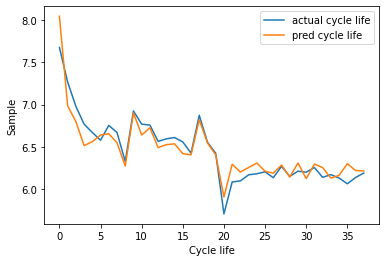

In [87]:
predict_and_plot(train_ind)

RMSE 273.76 MAE 107.39


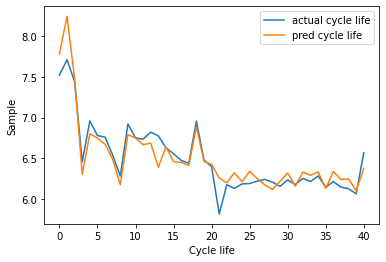

In [88]:
predict_and_plot(test_ind)

RMSE 165.79 MAE 125.18


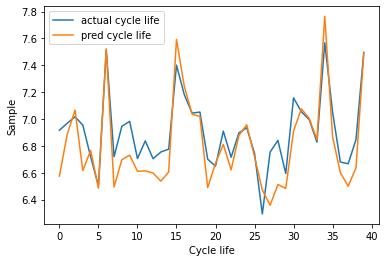

In [89]:
predict_and_plot(secondary_test_ind)